In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import pickle as pkl

from encode_state import EncodeState
from leakage import LeakageModels
from qutrit_model import QutritModel
from input_circuits import InputCircuits
from loss import DiscriminationLoss
from noise.noise_model import TwoQubitNoiseModel, two_qubit_depolarize
from backends.qc_backend import QCBackend

In this notebook we will use the qutrit model and the normal model to compare preformance on the
state discrimination task.
So, this requires 4 qubits in the vanilla model, and 6 qubits in the leaky model.

In [2]:
local_save = '../training_out/compare_models'
dt_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
checkpoint_path = os.path.join(local_save, dt_time)


In [3]:
n = 4
mu = 0.9
circuits = InputCircuits(n)
train_circuits, train_labels, test_circuits, test_labels = circuits.create_discrimination_circuits(100, mu_a=mu)
encoder = EncodeState(n)
leakage = LeakageModels(4, 2, True, 0.01)
qutrit_class = QutritModel(4, 0.01)
noise_model = TwoQubitNoiseModel(cirq.depolarize(0.01), two_qubit_depolarize(0.01))
noisy_sim = cirq.DensityMatrixSimulator(noise=noise_model)
aer_backend = QCBackend()

In [4]:
repetitions = 100
discrimination_model = encoder.discrimination_model()
leakage_model = leakage.leaky_model()
qutrit_model = qutrit_class.qutrit_model()
noisy_model = encoder.discrimination_model(backend=noisy_sim)
discrimination_aer = encoder.discrimination_model(backend=aer_backend, repetitions=repetitions)

discrimination_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'discrimination', 'discrimination.ckpt'),
    verbose = 1,
    save_weights_only=True)
leakage_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'leakage', 'leakage.ckpt'),
    verbose = 1,
    save_weights_only=True)
noisy_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'noisy', 'noisy.ckpt'),
    verbose = 1,
    save_weights_only=True)
qutrit_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path,  'qutrit', 'qutrit.ckpt'),
    verbose = 1,
    save_weights_only=True
)
aer_callback  = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path,  'aer_backend', 'aer_backend.ckpt'),
    verbose = 1,
    save_weights_only=True
)

/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.mul with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.mul instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()
/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.numbers with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.numbers instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()


In [5]:
lr = 0.01
loss = DiscriminationLoss(0.5, 0.5)
loss_fn = loss.discrimination_loss
discrimination_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                             loss = loss_fn,
                             metrics=['accuracy'])
leakage_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss = loss_fn,
                      metrics=['accuracy'])
noisy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss = loss_fn,
                    metrics=['accuracy'])
qutrit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss=loss_fn,
                     metrics=['accuracy'])
discrimination_aer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss=loss_fn,
                     metrics=['accuracy'])

Run these next three cells if you want to train a new model:

In [6]:
batch_size = 10
epochs = 5

In [7]:
leakage_history = leakage_model.fit(
                        x=train_circuits,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[leakage_callback])
with open(os.path.join(checkpoint_path, 'leakage', 'history.pkl'), 'wb') as f:
    pkl.dump(leakage_history.history, f)
with open(os.path.join(checkpoint_path, 'leakage', 'params.pkl'), 'wb') as f:
    pkl.dump(leakage_history.params, f)

Train on 70 samples, validate on 30 samples
Epoch 1/5
60/70 [========================>.....] - ETA: 1s - loss: 0.3280 - accuracy: 0.7000 
Epoch 00001: saving model to ../training_out/compare_models/2020_06_01_17_56_06/leakage/leakage.ckpt
70/70 [==============================] - 7s 97ms/sample - loss: 0.3324 - accuracy: 0.7429 - val_loss: 0.3249 - val_accuracy: 0.9333
Epoch 2/5
60/70 [========================>.....] - ETA: 0s - loss: 0.2959 - accuracy: 0.6167

In [7]:
%%time
discrimination_history = discrimination_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[discrimination_callback])

with open(os.path.join(checkpoint_path, 'discrimination', 'history.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.history, f)
with open(os.path.join(checkpoint_path, 'discrimination', 'params.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.params, f)

Train on 70 samples, validate on 30 samples
Epoch 1/5
60/70 [========================>.....] - ETA: 0s - loss: 0.3274 - accuracy: 0.6167 
Epoch 00001: saving model to ../training_out/compare_models/2020_06_02_10_40_20/discrimination/discrimination.ckpt
70/70 [==============================] - 3s 48ms/sample - loss: 0.3210 - accuracy: 0.5286 - val_loss: 0.3087 - val_accuracy: 0.0000e+00
Epoch 2/5
60/70 [========================>.....] - ETA: 0s - loss: 0.3043 - accuracy: 0.0000e+00

In [9]:
noisy_history = noisy_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[noisy_callback])
with open(os.path.join(checkpoint_path, 'noisy', 'history.pkl'), 'wb') as f:
    pkl.dump(noisy_history.history, f)
with open(os.path.join(checkpoint_path, 'noisy', 'params.pkl'), 'wb') as f:
    pkl.dump(noisy_history.params, f)

Train on 70 samples, validate on 30 samples
Epoch 1/5
60/70 [========================>.....] - ETA: 14s - loss: 0.2852 - accuracy: 0.0000e+00 
Epoch 00001: saving model to ../training_out/compare_models/2020_06_01_17_56_06/noisy/noisy.ckpt
70/70 [==============================] - 100s 1s/sample - loss: 0.2822 - accuracy: 0.0000e+00 - val_loss: 0.2834 - val_accuracy: 0.0000e+00
Epoch 2/5
60/70 [========================>.....] - ETA: 14s - loss: 0.2629 - accuracy: 0.0000e+00 

In [10]:
qutrit_history = qutrit_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[qutrit_callback])
with open(os.path.join(checkpoint_path, 'qutrit', 'history.pkl'), 'wb') as f:
    pkl.dump(qutrit_history.history, f)
with open(os.path.join(checkpoint_path, 'qutrit', 'params.pkl'), 'wb') as f:
    pkl.dump(qutrit_history.params, f)

Train on 70 samples, validate on 30 samples
Epoch 1/5
60/70 [========================>.....] - ETA: 9s - loss: 0.4844 - accuracy: 0.0000e+00  
Epoch 00001: saving model to ../training_out/compare_models/2020_06_01_17_56_06/qutrit/qutrit.ckpt
70/70 [==============================] - 64s 912ms/sample - loss: 0.4750 - accuracy: 0.0000e+00 - val_loss: 0.4136 - val_accuracy: 0.0000e+00
Epoch 2/5
60/70 [========================>.....] - ETA: 7s - loss: 0.3794 - accuracy: 0.0000e+00 

In [8]:
%%time
aer_history = discrimination_aer.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[aer_callback])

with open(os.path.join(checkpoint_path, 'aer_backend', 'history.pkl'), 'wb') as f:
    pkl.dump(aer_history.history, f)
with open(os.path.join(checkpoint_path, 'aer_backend', 'params.pkl'), 'wb') as f:
    pkl.dump(aer_history.params, f)

Train on 70 samples, validate on 30 samples
Epoch 1/5
60/70 [========================>.....] - ETA: 33s - loss: 0.3092 - accuracy: 0.0000e+00 
Epoch 00001: saving model to ../training_out/compare_models/2020_06_02_10_40_20/aer_backend/aer_backend.ckpt
70/70 [==============================] - 239s 3s/sample - loss: 0.3109 - accuracy: 0.0000e+00 - val_loss: 0.2954 - val_accuracy: 0.0000e+00
Epoch 2/5
60/70 [========================>.....] - ETA: 33s - loss: 0.2914 - accuracy: 0.0667     

Run this next cell if you'd rather load a pre-trained model:

In [12]:
save_point = sorted(os.listdir(local_save),
                     key=lambda x: datetime.datetime.strptime(x, '%Y_%m_%d_%H_%M_%S'))[-1]

models_dict = {}
models = [
    (leakage_model, 'leakage'),
    (discrimination_model, 'discrimination'),
    (noisy_model, 'noisy'),
    (qutrit_model, 'qutrit'),
    (discrimination_aer, 'aer_backend')
]
for model, folder in models:
    models_dict[folder] = {}
    models_dict[folder]['model'] = model
    path = os.path.join(local_save, save_point, folder)
    model.load_weights(os.path.join(path,  folder + '.ckpt'))
    # loss, acc = model.evaluate([test_circuits], [test_labels], verbose=1)
    # models_dict[folder]['loss'] = loss
    # models_dict[folder]['accuracy'] = acc
    with open(os.path.join(path, 'history.pkl'), 'rb') as f:
        models_dict[folder]['history'] = pkl.load(f)
    with open(os.path.join(path, 'params.pkl'), 'rb') as f:
        models_dict[folder]['params'] = pkl.load(f)

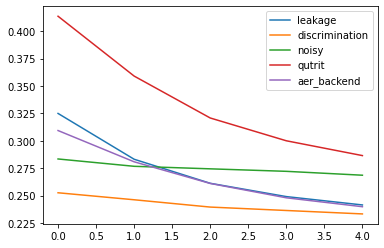

In [13]:
fig, ax = plt.subplots()
for model in models_dict.keys():
    ax.plot(models_dict[model]['history']['val_loss'], label=model)
plt.legend()

